# Iris Classification with K-Nearest Neighbors
This notebook demonstrates a simple case use of supervised machine learning for classification using the K-Nearest Neighbors (KNN) algorithm. With KNN, an object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (where k is a positive integer, and typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. In this example, KNN will be used on the popular iris dataset to predict species based on geometric features.

To help protect against overfitting, the model will be trained using 5-fold cross-validation and parameter tuning using GridSearchCV. In addition, the model will be tested for accuracy using a randomly selected 'hold-out' dataset. 

Finally, given that the data used for prediction is multidimensional, dimensionality reduction will be performed using principal component analysis, for the purpose of easy visualization in 2D space.

#### Import libraries to be used
This classification task uses pandas for preprocessing, seaborn for visualization, and sklearn for model optimization and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns

#### Data Preprocessing 

The datasets from sklearn do not come in an array format. Some preprocessing is required.

In [2]:
iris_data = load_iris()

dataframe = pd.DataFrame(data = iris_data.data, 
                         columns = [i[:len(i)-5] for i in iris_data.feature_names])

dataframe['species'] = [iris_data.target_names[i] for i in iris_data.target] 

dataframe.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


#### Exploratory Analysis
The purpose of this task is to predict species class (setosa,versicolor, or virginica) based on each flowers geometric features  and the mode of species classes of its k-nearest neighbors.The geometric features are sepal length, sepal width, petal length, petal width.

However, when visualizing the relationships of these features to each other in a pairplot, the overlap between virginica and versicolor can be seen. Thus the task is more difficult than it may have seemed. 

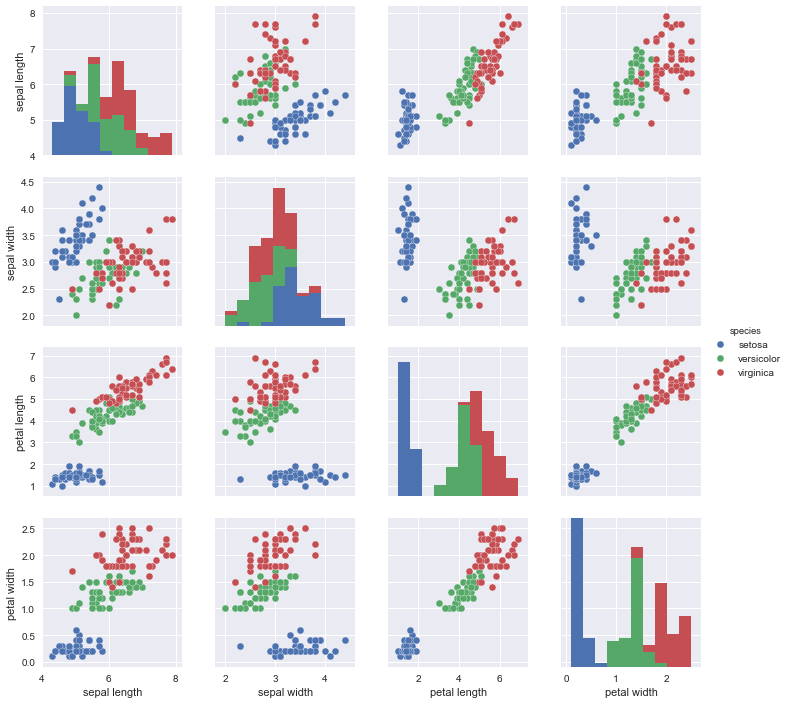

In [3]:
sns.pairplot(dataframe,hue='species')
plt.show()

#### Predictive Model Creation and Parameter Tuning

The data will first be randomly split the into train and test data sets. The model will be trained with GridSearchCV, which will use 5 fold cross validation and parameter tuning for number of neighbors, weights, and algorithm. The best performing parameters will be selected to when fitting the final model to be used for prediction.

In [4]:
#seperate data into features (used to make the prediction) and targets (the variable being predicted)

X = dataframe[['sepal length', 'sepal width', 'petal length', 'petal width']]
y = dataframe['species']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

# a classifier is created
knn_clf = KNeighborsClassifier()
params = {'n_neighbors':[3,5,7,9],'weights':['uniform','distance'],
          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_clf = GridSearchCV(knn_clf,param_grid=params,cv=5)
grid_clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [5]:
grid_clf.best_params_

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}

In [6]:
clf = grid_clf.best_estimator_

#### Model Performance Evalution
The mean accuracy of the cross validated model is ~94%. However, when the model is used make predictions on the previously unseen test data, it predicts with ~ 98% accuracy. Of the 50 predictions made, one value was predicted in error. The confusion matrix below reveals that it was a viginica that was mislabeled as a versicolor. The scatter plots below show which datapoint was mislabled on an xy axis of the data's principal components after dimensionality reduction has been applied.

In [7]:
print("Mean Cross Validated Accuracy: {}".format(grid_clf.best_score_))
print("Test Data Prediction Accuracy: {} ".format(clf.score(X_test,y_test)))

Mean Cross Validated Accuracy: 0.94
Test Data Prediction Accuracy: 0.98 


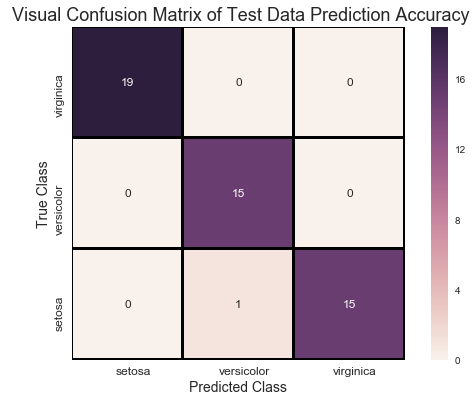

In [8]:
predicted_vals = clf.predict(X_test)
classes = iris_data.target_names
conf_mtx = confusion_matrix(y_test,predicted_vals)
sns.heatmap(conf_mtx,square=True,annot=True,cbar=True,linecolor='k',linewidths= 2)
plt.title(' Visual Confusion Matrix of Test Data Prediction Accuracy',fontsize = 18)
tick_marks = np.arange(0.55, len(classes))
plt.xticks(tick_marks, classes,fontsize = 12)
plt.yticks(tick_marks, classes,fontsize = 12)
plt.tight_layout()
plt.ylabel('True Class',fontsize = 14)
plt.xlabel('Predicted Class',fontsize = 14)
plt.show()

In [9]:
#prepare dataframe to use for plotting

#PCA for dimesionality reduction
pd.options.mode.chained_assignment = None 
model = PCA(n_components=2)
model.fit(X_test)
X_2D = model.transform(X_test)

#append dataframe
X_test['Principal Component 1'], X_test['Principal Component 2'] = X_2D[:, 0],X_2D[:, 1]
X_test['species'] = y_test
X_test['predicted'] = predicted_vals
X_test['Correct Prediction'] = X_test['species'] == X_test['predicted']


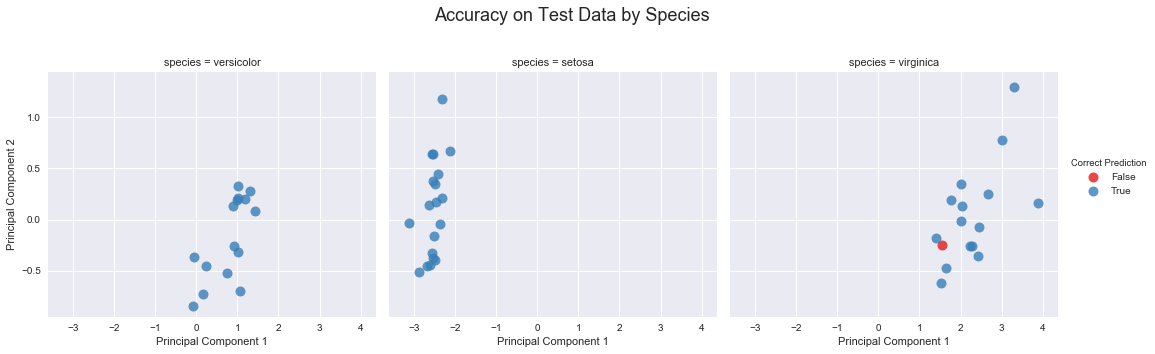

In [10]:
#create plots

plot_params ={'s':100}

sns.lmplot(x ='Principal Component 1',
           y ='Principal Component 2',
           hue = 'Correct Prediction',
           palette ='Set1',
           col = 'species',
           data = X_test, 
           fit_reg=False,
           scatter_kws= plot_params)

plt.subplots_adjust(top=0.8)
plt.suptitle('Accuracy on Test Data by Species', fontsize = 18)

plt.show()

#### Summary:
Given that parameter k is small (k=3), this model is likely fit to have high variance. High variance may suggest overfitting. However, in this case the model performed fairly well on the previosly unseen test data with an accuracy of ~98%, better than the mean crossvalidated score of 94% on the training data. This suggests that the model is not overfit, and could be a good predictor of species if given similar data. 